#Загрузка текста

Для построения словаря будем использовать word2vec из gensim

In [ ]:
from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count

word2vec = Word2Vec(min_count = 1, workers=cpu_count(), window=5, sg=1)

Текст "Мастер и маргарита" 

In [ ]:
file = open('master.txt', mode='r')
text = file.read()
file.close()

#Базовая предобработка и создание словаря 

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Разделение текста по главам

In [ ]:
chapter = [word_tokenize(i) for i in text.split(sep='Глава')][1:]

Удаление знаков препинания и стоп слов

In [ ]:
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

def standardize_text(df):
  stop_words = stopwords.words('russian')
  stop_words.extend(string.punctuation)
  stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–',
                     'к','на', '...', '..', '«', '»', '', '\n','Глава','==','==='])
  
  df = [i.lower() for i in df if (i not in stop_words)]

  return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
chapter = [standardize_text(i) for i in chapter]

In [ ]:
word2vec.build_vocab(chapter)
word2vec.train(chapter, total_examples=64, epochs=10)

(745918, 752550)

In [ ]:
word2vec.most_similar('берлиоз')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('профессор', 0.9957313537597656),
 ('подумал', 0.9940712451934814),
 ('бездомный', 0.9934359788894653),
 ('знаю', 0.9930907487869263),
 ('тихо', 0.9930883646011353),
 ('воскликнул', 0.990914523601532),
 ('не', 0.9903339147567749),
 ('стравинский', 0.9903137683868408),
 ('афраний', 0.9899523258209229),
 ('могу', 0.9895820617675781)]

#Загрузка датасета

In [ ]:
!pip install pymorphy2 
import pandas as pd
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
import pandas as pd

data = pd.read_csv('1.txt')

In [ ]:
data['ID'] = 1

for i in range(len(data)):
  data['ID'][i] =  word2vec.wv.vocab[data['Word'][i]].index
  data['Word'][i] = morph.parse(data['Word'][i])[0].normal_form

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
data.head()

,Sentence #,Word,BIO-Tag,ID
0,1,однажды,O,1967
1,1,весною,O,3866
2,1,час,B-TIME,323
3,1,небывалый,O,9375
4,1,жаркий,O,5572


In [ ]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['BIO-Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [ ]:
data['Tag_idx'] = data['BIO-Tag'].map(tag2idx)

In [ ]:
# Fill na
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(['Sentence #'],as_index=False)['Word', 'BIO-Tag', 'ID', 'Tag_idx'].agg(lambda x: list(x))

data_group.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,Sentence #,Word,BIO-Tag,ID,Tag_idx
0,1,"[однажды, весною, час, небывалый, жаркий, зака...","[O, O, B-TIME, O, O, O, B-LOC, B-LOC, I-LOC, O...","[1967, 3866, 323, 9375, 5572, 5573, 151, 294, ...","[10, 10, 11, 10, 10, 10, 2, 2, 8, 10, 1]"
1,2,"[первый, одетый, летний, серенький, пара, мале...","[B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[235, 1265, 5574, 9376, 2357, 1113, 1454, 9377...","[1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10..."
2,3,"[второй, плечистый, рыжеватый, вихрастый, моло...","[B-PER, O, O, O, B-PER, I-PER, O, O, O, O, O, ...","[131, 9382, 5576, 9383, 516, 18, 9384, 1266, 9...","[1, 10, 10, 10, 1, 7, 10, 10, 10, 10, 10, 10, ..."
3,4,"[первый, иной, михаил, александрович, берлиоз,...","[B-PER, O, B-PER, I-PER, I-PER, B-PER, O, O, O...","[235, 2900, 995, 996, 55, 344, 1455, 264, 9388...","[1, 10, 1, 7, 7, 1, 10, 10, 10, 0, 5, 5, 10, 1..."
4,5,"[попасть, тень, зеленеть, липа, писатель, перв...","[O, O, O, O, B-PER, O, O, O, O, O, O, O, O, O]","[2902, 997, 5582, 2903, 2904, 517, 909, 1660, ...","[10, 10, 10, 10, 1, 10, 10, 10, 10, 10, 10, 10..."


In [ ]:
maxlen_word = max([len(s) for s in data_group['ID']])
#maxlen_word = 20
maxlen_tag = max([len(s) for s in data_group['Tag_idx']])

In [ ]:
n_token = len(list(set(data['Word'].to_list())))
n_tag = len(list(set(data['BIO-Tag'].to_list())))

In [ ]:
from keras.preprocessing.sequence import pad_sequences

data_group['ID'] = [pad_sequences([i], maxlen=maxlen_word, dtype='int32', padding='post', value=n_token) for i in data_group['ID']]
data_group['Tag_idx'] = [pad_sequences([i], maxlen=maxlen_tag, dtype='int32', padding='post', value= tag2idx['O']) for i in data_group['Tag_idx']]

In [ ]:
import numpy as np

data_group['ID'] = [np.array(i).flatten() for i in data_group['ID']]
data_group['Tag_idx'] = [np.array(i).flatten() for i in data_group['Tag_idx']]

In [ ]:
!pip install keras.utils

  Created wheel for keras.utils: filename=keras_utils-1.0.13-cp37-none-any.whl size=2657 sha256=9798e7bb5c62e2196f3edf60c778f9136a4f698d9a5fbe11f88f1ca042512a72
  Stored in directory: /root/.cache/pip/wheels/46/25/27/7707005c1cb27e1ffc8277b004ac295e34767b02b44d73d6be
Successfully built keras.utils


In [ ]:
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split

def get_pad_train_test_val(data_group, data):

    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag_idx'].to_list())))

    tokens = data_group['ID'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token)

    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= 1)
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.2, train_size=0.8, shuffle=True)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.2,train_size =0.8, shuffle=True)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)


train_tokens length: 189 
train_tokens length: 189 
test_tokens length: 60 
test_tags: 60 
val_tokens: 48 
val_tags: 48


In [ ]:
input_dim = len(word2vec.wv.vocab)+1
output_dim = 32
input_length = max([len(s) for s in data_group['ID']])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  23866 
output_dim:  32 
input_length:  50 
n_tags:  14


In [ ]:
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model, to_categorical
import matplotlib.pyplot as plt


def get_bilstm_lstm_model():
    model = Sequential()

    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.2), merge_mode = 'concat'))

    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    model.add(TimeDistributed(Dense(n_tags, activation="tanh")))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
import time
from tqdm import tqdm

In [ ]:
def train_model(X, y, model):
  hist = model.fit(X, y, verbose=1, epochs=100, validation_split=0.15)
  return hist

In [ ]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

In [ ]:
model_bilstm_lstm.evaluate(test_tokens, np.array(test_tags))

In [ ]:
def show(data, pred, true):
  k = np.random.randint(0,data.shape[0])
  print("Номер предложения {} из {} (тестовая выборка)".format(k, data.shape[0]))
  print("{:15}||{:5}||{}".format("Слово", "Предсказанная", "Фактическая"))

  for i in range(len(data[k])):
    if data[k][i] != n_token:
      print("{:15}: {:14} {}".format(word2vec.wv.index2word[data[k][i]], idx2tag[pred[k][i].argmax()], idx2tag[true[k][i].argmax()]))

In [ ]:
def show_(data, pred):
  for i in range(len(data)):
    if data[i] != n_token:
      print("{:15}: {:5} {}".format(word2vec.wv.index2word[data[i]], idx2tag[pred[i].argmax()]))

In [ ]:
model_bilstm_lstm.fit(train_tokens, np.array(train_tags), epochs=35)

In [ ]:
model_bilstm_lstm.fit(test_tokens, np.array(test_tags), epochs=20)

In [ ]:
a = model_bilstm_lstm.predict(test_tokens)

In [ ]:
show(test_tokens, a, test_tags)

Номер предложения 52 из 60 (тестовая выборка)
Слово          ||Предсказанная||Фактическая
торопливо      : O              O
отозвался      : O              O
арестованный   : B-PER          B-PER
всем           : O              O
существом      : O              O
выражая        : O              O
готовность     : O              O
отвечать       : O              O
толково        : O              O
вызывать       : O              O
гнева          : O              O


In [ ]:
pred = [[idx2tag[i.argmax()]  for i in row] for row in a]
true_ = [[idx2tag[i.argmax()] for i in row] for row in test_tags]

pred = np.array(pred).flatten()
true_ = np.array(true_).flatten()

In [ ]:
from sklearn.metrics import classification_report
 
report = classification_report(y_pred=pred, y_true=true_)
print(report)

              precision    recall  f1-score   support

      B-DATE       0.00      0.33      0.01         3
       B-LOC       0.00      0.14      0.00         7
       B-NUM       0.00      0.00      0.00         4
       B-PER       0.25      0.22      0.23        77
      B-TIME       0.00      0.00      0.00         3
      I-DATE       0.00      0.00      0.00         3
       I-LOC       0.00      0.00      0.00         1
       I-NUM       0.00      0.00      0.00         1
       I-PER       0.00      0.00      0.00         6
      I-TIME       0.00      0.00      0.00         1
           O       0.00      0.00      0.00      2894

    accuracy                           0.01      3000
   macro avg       0.02      0.06      0.02      3000
weighted avg       0.01      0.01      0.01      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
per = data.loc[data['BIO-Tag'].isin(['B-PER', 'I-PER'])]

In [ ]:
vocab_n = []

per = per.groupby(['Sentence #'],as_index=False)['Word', 'BIO-Tag'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


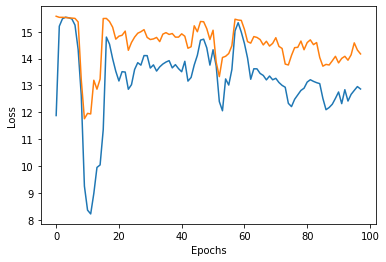

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results.history['loss'][2:])
plt.plot(results.history['val_loss'][2:])
plt.xlabel('Epochs');
plt.ylabel('Loss');

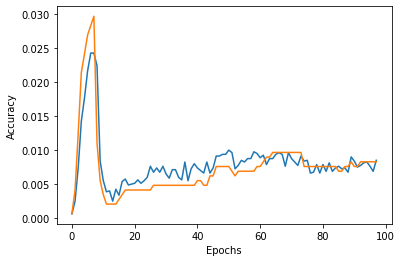

In [ ]:
plt.plot(results.history['accuracy'][2:])
plt.plot(results.history['val_accuracy'][2:])
plt.xlabel('Epochs');
plt.ylabel('Accuracy');

In [ ]:
uniform_data

array([[0.81928182, 0.39065678, 0.13274454, 0.45206721, 0.53521067,
        0.70764372, 0.45682217, 0.99504619, 0.54547367, 0.89984006,
        0.08692279, 0.76168914],
       [0.4355571 , 0.21840411, 0.59202932, 0.98617892, 0.29171418,
        0.40597913, 0.49395946, 0.56732728, 0.82429741, 0.48133541,
        0.40774671, 0.85701461],
       [0.9811942 , 0.02301693, 0.44441919, 0.79143501, 0.91846883,
        0.34905638, 0.91866758, 0.32529252, 0.42781505, 0.47928912,
        0.15386083, 0.24783168],
       [0.74153987, 0.39922954, 0.84311385, 0.48336885, 0.63082501,
        0.22005971, 0.39746643, 0.12173147, 0.79923006, 0.97587342,
        0.45185205, 0.52132537],
       [0.6993862 , 0.00968184, 0.87230741, 0.17074963, 0.70915983,
        0.3971348 , 0.01437514, 0.37048294, 0.03508064, 0.22920043,
        0.07276733, 0.77244307],
       [0.20616726, 0.59541318, 0.14813519, 0.29542699, 0.98396542,
        0.83724838, 0.56695707, 0.0339465 , 0.38239168, 0.32642878,
        0.42319863,

In [ ]:
pred_map = [[i.argmax()  for i in row] for row in a]
true_map = [[i.argmax() for i in row] for row in test_tags]

In [ ]:
pred_map

In [ ]:
import seaborn as sns

sns.heatmap(pred_map, annot = True)


#WIKI

In [ ]:
!pip install wikipedia

In [ ]:
import wikipedia

wikipedia.set_lang("ru")

In [ ]:
word2vec.most_similar('человек')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('площадь', 0.9991255402565002),
 ('города', 0.9988244771957397),
 ('николая', 0.9988203048706055),
 ('записи', 0.9984771013259888),
 ('17', 0.9983648061752319),
 ('под', 0.998350203037262),
 ('третьей', 0.998348593711853),
 ('бахтадзе', 0.9982965588569641),
 ('истории', 0.9982510805130005),
 ('умер', 0.9981808066368103)]

In [ ]:
page = []

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


5

In [ ]:
from tqdm import tqdm 

for i in tqdm(range(500)):
  try:
    page.append(standardize_text(word_tokenize(wikipedia.page(wikipedia.random()).content)))
  except:
    print('err')

word2vec.build_vocab(page, update=True)
word2vec.train(page, total_examples=word2vec.corpus_count, epochs=word2vec.iter)

  0%|          | 1/500 [00:02<17:56,  2.16s/it]/usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
  0%|          | 2/500 [00:03<15:24,  1.86s/it]

err


  2%|▏         | 12/500 [00:20<13:44,  1.69s/it]

err


  3%|▎         | 16/500 [00:27<13:55,  1.73s/it]

err


  7%|▋         | 37/500 [01:07<17:05,  2.21s/it]

err


  9%|▊         | 43/500 [01:19<14:07,  1.86s/it]

err


 10%|█         | 51/500 [01:32<11:28,  1.53s/it]

err


 10%|█         | 52/500 [01:33<10:30,  1.41s/it]

err


 12%|█▏        | 59/500 [01:46<11:56,  1.63s/it]

err


 13%|█▎        | 66/500 [01:59<13:15,  1.83s/it]

err


 14%|█▎        | 68/500 [02:02<10:36,  1.47s/it]

err


 18%|█▊        | 92/500 [02:45<11:23,  1.67s/it]

err


 19%|█▉        | 96/500 [02:53<12:28,  1.85s/it]

err


 20%|██        | 102/500 [03:03<10:59,  1.66s/it]

err


 28%|██▊       | 142/500 [04:26<10:41,  1.79s/it]

err


 30%|██▉       | 148/500 [04:35<08:40,  1.48s/it]

err


 32%|███▏      | 160/500 [04:58<08:45,  1.55s/it]

err


 34%|███▍      | 171/500 [05:14<08:09,  1.49s/it]

err


 35%|███▍      | 174/500 [05:18<06:41,  1.23s/it]

err


 41%|████      | 205/500 [06:10<06:59,  1.42s/it]

err


 42%|████▏     | 210/500 [06:18<07:07,  1.47s/it]

err


 43%|████▎     | 214/500 [06:25<07:06,  1.49s/it]

err


 46%|████▌     | 229/500 [06:51<06:37,  1.47s/it]

err


 46%|████▌     | 230/500 [06:52<06:05,  1.35s/it]

err


 47%|████▋     | 234/500 [06:59<07:03,  1.59s/it]

err


 53%|█████▎    | 265/500 [07:54<05:09,  1.32s/it]

err


 54%|█████▎    | 268/500 [08:00<05:54,  1.53s/it]

err


 57%|█████▋    | 285/500 [08:31<05:53,  1.64s/it]

err


 58%|█████▊    | 291/500 [08:41<05:34,  1.60s/it]

err


 61%|██████    | 305/500 [09:07<05:03,  1.56s/it]

err


 62%|██████▏   | 309/500 [09:13<04:43,  1.49s/it]

err


 65%|██████▌   | 325/500 [09:39<04:10,  1.43s/it]

err


 70%|██████▉   | 349/500 [10:19<03:30,  1.40s/it]

err


 70%|███████   | 351/500 [10:24<04:22,  1.76s/it]

err


 76%|███████▌  | 379/500 [11:11<02:50,  1.41s/it]

err


 79%|███████▉  | 397/500 [11:47<03:08,  1.83s/it]

err


 85%|████████▍ | 423/500 [12:33<02:06,  1.65s/it]

err


 86%|████████▌ | 431/500 [12:47<01:54,  1.66s/it]

err


 90%|████████▉ | 448/500 [13:15<01:14,  1.44s/it]

err


 90%|████████▉ | 449/500 [13:16<01:08,  1.34s/it]

err


 93%|█████████▎| 467/500 [13:53<01:07,  2.03s/it]

err


 94%|█████████▍| 471/500 [14:02<00:54,  1.87s/it]

err


 97%|█████████▋| 485/500 [14:25<00:23,  1.57s/it]

err


 98%|█████████▊| 491/500 [14:35<00:13,  1.49s/it]

err


 98%|█████████▊| 492/500 [14:36<00:11,  1.40s/it]

err


100%|██████████| 500/500 [14:50<00:00,  1.78s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  # Remove the CWD from sys.path while we load stuff.
